In [1]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import matplotlib.pyplot as plt
import math

import os
import time
import timeit
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Flatten
from keras.datasets import mnist
from keras.models import Sequential
from sklearn.preprocessing import normalize
from tensorflow.keras.optimizers import SGD
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import ZeroPadding1D
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten,GRU

import warnings
warnings.filterwarnings('ignore')

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-n__u__85
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-n__u__85
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28111 sha256=d47fae3c47d945fe0fdca28009ab269b66152a7930e51e10953e077a746e1918
  Stored in directory: /tmp/pip-ephem-wheel-cache-u5jlh85k/wheels/a8/c4/1a/cee09dcc12a11620066d35ace42e3c1e3bfbcc1db3a0ce7788
Successfully built pyeeg


In [2]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network

# Data manipulation
import pandas as pd # for data manipulation
import numpy as np # for data manipulation

# Sklearn
import sklearn
from sklearn.preprocessing import MinMaxScaler # for feature scaling
import plotly 
import plotly.express as px
import plotly.graph_objects as go

In [3]:
channel = [1,2,3,4,7,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,30,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = [
    '01','02','03','04','05','06','07','08','09','10'
    ,'11','12','13','14','15','16','17','18','19','20'
    ,'21','22','23','24','25','26','27','28','29','30'
    ,'31','32'
]
#List of subjects

In [4]:
def label_mapping(valence, arousal):
    # HVHA, HVLA, LVHA, and LVLA
    
    if (valence > 5 and arousal > 5):
        label = 0 #'HVHA'
    elif (valence > 5 and arousal <= 5):
        label = 1 #'HVLA'
    elif (valence <= 5 and arousal > 5):
        label = 2 #'LVHA'
    elif (valence <= 5 and arousal <= 5):
        label = 3 #'LVLA'
    
    return label

def map_label(label):
    new_label = label_mapping(label[0], label[1]) 
    return new_label

In [5]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/kaggle/input/deap-dataset/data_preprocessed_python/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            labels = np.array(map_label(labels))
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])


                meta.append([np.array(meta_data), np.array(labels)])    
                start = start + step_size
                
        meta = np.array(meta, dtype = object)
        np.save('s' + sub, meta, allow_pickle=True, fix_imports=True)

In [6]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [7]:
data = []
label = []

for subjects in subjectList:

    with open('/kaggle/working/s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
            data.append(sub[i][0])
            label.append(sub[i][1])

np.save('data', np.array(data), allow_pickle=True, fix_imports=True)
np.save('label', np.array(label), allow_pickle=True, fix_imports=True)
print("Training datasets:", np.array(data).shape, np.array(label).shape)

Training datasets: (624640, 70) (624640,)


In [8]:
with open('/kaggle/working/data.npy', 'rb') as fileTrain:
    data  = np.load(fileTrain)
    
with open('/kaggle/working/label.npy', 'rb') as fileTrainL:
    label  = np.load(fileTrainL)

In [9]:
from sklearn.model_selection import train_test_split
x_train, x, y_train, y = train_test_split(data, label, test_size=0.4, random_state=42)

In [10]:
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

In [11]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [12]:
np.save('x_train', np.array(x_train), allow_pickle=True, fix_imports=True)
np.save('y_train', np.array(y_train), allow_pickle=True, fix_imports=True)
np.save('x_val', np.array(x_val), allow_pickle=True, fix_imports=True)
np.save('y_val', np.array(y_val), allow_pickle=True, fix_imports=True)
np.save('x_test', np.array(x_test), allow_pickle=True, fix_imports=True)
np.save('y_test', np.array(y_test), allow_pickle=True, fix_imports=True)

In [13]:
with open('/kaggle/working/x_train.npy', 'rb') as file:
    x_train = np.load(file, allow_pickle=True)
with open('/kaggle/working/y_train.npy', 'rb') as file:
    y_train = np.load(file, allow_pickle=True)
with open('/kaggle/working/x_val.npy', 'rb') as file:
    x_val = np.load(file, allow_pickle=True)
with open('/kaggle/working/y_val.npy', 'rb') as file:
    y_val = np.load(file, allow_pickle=True)
with open('/kaggle/working/x_test.npy', 'rb') as file:
    x_test = np.load(file, allow_pickle=True)
with open('/kaggle/working/y_test.npy', 'rb') as file:
    y_test = np.load(file, allow_pickle=True)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(normalize(x_train))
x_val = scaler.fit_transform(normalize(x_val))
x_test = scaler.fit_transform(normalize(x_test))

In [15]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0],x_test.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [16]:
x_train.shape

(374784, 70, 1)

In [17]:
batch_size = 256
num_classes = 4
epochs = 200
input_shape=(x_train.shape[1], 1)

In [18]:
print(input_shape)

(70, 1)


In [19]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense,GRU,LSTM
from keras.regularizers import l2

In [20]:
from keras.models import load_model
from keras.layers import Lambda
import tensorflow as tf

In [21]:
model_2 = Sequential()

model_2.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Dropout(0.2))

model_2.add(Conv1D(128, 3,  activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Dropout(0.2))

model_2.add(GRU(units = 256, return_sequences=True))  
model_2.add(Dropout(0.2))

model_2.add(GRU(units = 32))
model_2.add(Dropout(0.2))

model_2.add(Flatten())

model_2.add(Dense(units = 128, activation='relu'))
model_2.add(Dropout(0.2))

model_2.add(Dense(units = num_classes))
model_2.add(Activation('softmax'))

model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 68, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 16, 256)        │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,820 (1.45 MB)

 Trainable params: 378,820 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model_2.compile(
    optimizer ="adam",
    loss = 'categorical_crossentropy',
    metrics=["accuracy"]
)

In [23]:
history_2 = model_2.fit(
    x_train, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.3816 - loss: 1.3023 - val_accuracy: 0.4795 - val_loss: 1.1552
Epoch 2/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.4759 - loss: 1.1595 - val_accuracy: 0.5234 - val_loss: 1.0751
Epoch 3/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5149 - loss: 1.0905 - val_accuracy: 0.5577 - val_loss: 1.0065
Epoch 4/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5446 - loss: 1.0354 - val_accuracy: 0.5829 - val_loss: 0.9589
Epoch 5/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5654 - loss: 0.9952 - val_accuracy: 0.5983 - val_loss: 0.9236
Epoch 6/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5845 - loss: 0.9585 - val_accuracy: 0.6200 - val_loss: 0.8874
Epoch 7/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5982 - loss: 0.9311 - val_accuracy: 0.6334 - val_loss: 0.8600
Epoch 8/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 

In [24]:
score_2 = model_2.evaluate(x_train, y_train, verbose=1)
print('Train loss:', score_2[0])
print('Train accuracy:', score_2[1])

11712/11712 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.8565 - loss: 0.3807
Train loss: 0.3820672333240509
Train accuracy: 0.8560184240341187


In [25]:
score_2 = model_2.evaluate(x_val, y_val, verbose=1)
print('Val loss:', score_2[0])
print('Val accuracy:', score_2[1])

3904/3904 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7901 - loss: 0.5352
Val loss: 0.5343298316001892
Val accuracy: 0.7917600274085999


In [26]:
score_2 = model_2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

3904/3904 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7886 - loss: 0.5399
Test loss: 0.5397313833236694
Test accuracy: 0.7892385721206665


In [27]:
model_2.save('gru_model.h5')
np.save('gru_model.npy', history_2.history)

In [28]:
# list all data in history
print(history_2.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


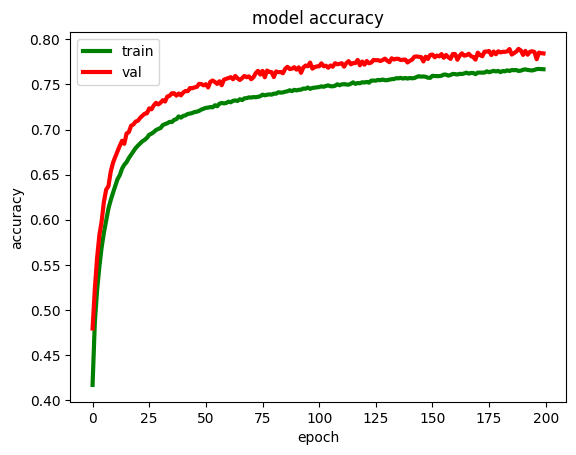

In [29]:
# summarize history for accuracy
plt.plot(history_2.history['accuracy'],color='green',linewidth=3.0)
plt.plot(history_2.history['val_accuracy'],color='red',linewidth=3.0)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.savefig("model accuracy.png")
plt.show()


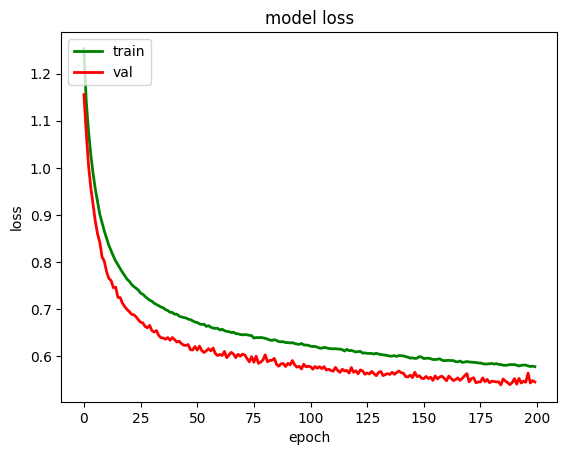

In [30]:
# summarize history for loss
plt.plot(history_2.history['loss'],color='green',linewidth=2.0)
plt.plot(history_2.history['val_loss'],color='red',linewidth=2.0)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.savefig("model loss.png")
plt.show()


In [31]:
M=history_2

In [34]:

from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import seaborn as sns

3904/3904 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


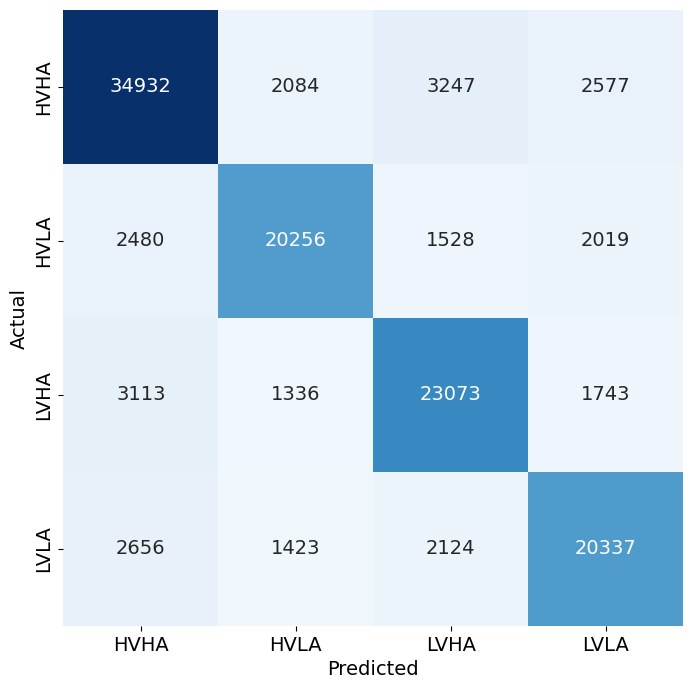

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.81      0.82      0.81     42840
           1       0.81      0.77      0.79     26283
           2       0.77      0.79      0.78     29265
           3       0.76      0.77      0.76     26540

    accuracy                           0.79    124928
   macro avg       0.79      0.79      0.79    124928
weighted avg       0.79      0.79      0.79    124928



In [35]:
class_names = ['HVHA', 'HVLA', 'LVHA', 'LVLA']

y_pred = model_2.predict(x_test)

y_predict = []

for i in range(len(y_pred)):
    y_predict.append(np.argmax(y_pred[i]))

y_predict = np.array(y_predict)
yt_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(yt_test, y_predict)
clr = classification_report(yt_test, y_predict)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues', annot_kws={"size":14})
plt.xticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.yticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
# plt.title("Confusion Matrix for GRU Model")
plt.show()

print("Classification Report:\n----------------------\n", clr)